# Курсовой проект по курсу PyTorch: 1-я модель классификатора

Ссылка на датасет: https://www.kaggle.com/gti-upm/leapgestrecog/version/1

## Подключение библиотек и загрузка датасета

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
import pandas as pd
import time
from torch.nn import functional as F
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from google.colab import files

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d gti-upm/leapgestrecog
!unzip -q /content/leapgestrecog.zip -d /content/ds

100% 2.12G/2.13G [00:26<00:00, 86.4MB/s]
100% 2.13G/2.13G [00:26<00:00, 86.2MB/s]


## Формирование словарей с названиями классов и соответствующими им номерами классов

In [5]:
classes = os.listdir('/content/ds/leapgestrecog/leapGestRecog/00/')
classes

['08_palm_moved',
 '04_fist_moved',
 '03_fist',
 '05_thumb',
 '02_l',
 '10_down',
 '09_c',
 '01_palm',
 '07_ok',
 '06_index']

In [6]:
class_to_index = {}
index_to_class = {}
for i, class_name in enumerate(classes):
  class_to_index[class_name] = i
  index_to_class[i] = class_name

In [7]:
class_to_index

{'01_palm': 7,
 '02_l': 4,
 '03_fist': 2,
 '04_fist_moved': 1,
 '05_thumb': 3,
 '06_index': 9,
 '07_ok': 8,
 '08_palm_moved': 0,
 '09_c': 6,
 '10_down': 5}

In [8]:
index_to_class

{0: '08_palm_moved',
 1: '04_fist_moved',
 2: '03_fist',
 3: '05_thumb',
 4: '02_l',
 5: '10_down',
 6: '09_c',
 7: '01_palm',
 8: '07_ok',
 9: '06_index'}

## Подготовка данных для датасета

In [9]:
# Собираем все адреса картинок для добавления в df
images_addr = []
for root, dirs, files in os.walk('/content/ds/leapGestRecog'):
    for name in files:
        f = os.path.join(root, name)
        images_addr.append(f)

In [10]:
len(images_addr)

20000

In [11]:
dataframe = pd.DataFrame(images_addr, columns=['images_addr'])
dataframe.head()

,images_addr
0,/content/ds/leapGestRecog/05/08_palm_moved/fra...
1,/content/ds/leapGestRecog/05/08_palm_moved/fra...
2,/content/ds/leapGestRecog/05/08_palm_moved/fra...
3,/content/ds/leapGestRecog/05/08_palm_moved/fra...
4,/content/ds/leapGestRecog/05/08_palm_moved/fra...


In [12]:
# Сформируем индекс напротив адреса каждой картинки в dataframe

# Вырезаем из адресов имена классов
dataframe['class_index'] = dataframe['images_addr'].apply(lambda x: x.split('/')[5])
dataframe.head()

,images_addr,class_index
0,/content/ds/leapGestRecog/05/08_palm_moved/fra...,08_palm_moved
1,/content/ds/leapGestRecog/05/08_palm_moved/fra...,08_palm_moved
2,/content/ds/leapGestRecog/05/08_palm_moved/fra...,08_palm_moved
3,/content/ds/leapGestRecog/05/08_palm_moved/fra...,08_palm_moved
4,/content/ds/leapGestRecog/05/08_palm_moved/fra...,08_palm_moved


In [13]:
# Проверим правильность полученных имен классов
dataframe['class_index'].unique()

array(['08_palm_moved', '04_fist_moved', '03_fist', '05_thumb', '02_l',
       '10_down', '09_c', '01_palm', '07_ok', '06_index'], dtype=object)

In [14]:
# Произведем замену имени класса на индекс класса
dataframe['class_index'] = dataframe['class_index'].apply(lambda x: class_to_index[x])

In [15]:
# Проверим правильность замены
dataframe['class_index'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
# Проверим сбалансированность классов
dataframe['class_index'].value_counts()

9    2000
8    2000
7    2000
6    2000
5    2000
4    2000
3    2000
2    2000
1    2000
0    2000
Name: class_index, dtype: int64

In [17]:
# Проверим размерность первой картинки
image_arr = dataframe['images_addr'][0]
img = np.asarray(Image.open(image_arr)).astype('float')
img.shape

(240, 640)

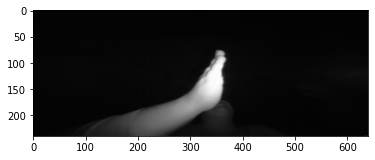

In [18]:
# Отобразим эту картинку
plt.imshow(img, cmap='gray')
plt.show()

In [19]:
# Ее класс
index_to_class[dataframe['class_index'][0]]

'08_palm_moved'

## Класс для кастомного датасета

In [20]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, dataframe):
        # Подаем наш подготовленный датафрейм
        self.dataframe = dataframe
        
        # Разделяем датафрейм на адреса картинок
        self.images_addr_arr = self.dataframe.iloc[:,0]
        # и номера классов
        self.class_index_arr = self.dataframe.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.dataframe.index)

    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        image = np.asarray(Image.open(self.images_addr_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        image = torch.as_tensor(image)/255
        # Добавляем батч измерение
        image = image.unsqueeze(0)
        # Без этого дополнительного измерения интерполяция не работает
        image = image.unsqueeze(0)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с HхW на 256х256
        # clamp не позволяет выйти за границы
        image = F.interpolate(input=image, size=256, align_corners=False, mode='bicubic').clamp(min=0, max=1)
        # Возвращаемся к 4-м измерениям
        image = image.squeeze(1)
        
        # Читаем индекс класса 
        class_index = self.class_index_arr[index].astype('int')
        
        return (image.float(), class_index)

    def __len__(self):
        return self.data_len

## Разделение на тренировочную и тестовую выбоки

In [21]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(dataframe, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [22]:
train_data_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=16, shuffle=False)

## Проверка работы загрузчика

In [23]:
loader = iter(train_data_loader)
image, class_index = loader.next()

In [24]:
image.shape

torch.Size([16, 1, 256, 256])

In [25]:
class_index.shape

torch.Size([16])

In [26]:
class_index

tensor([3, 3, 6, 6, 4, 3, 3, 9, 7, 3, 3, 2, 9, 4, 7, 7])

In [27]:
torch.unique(image).max()

tensor(1.)

In [28]:
torch.unique(image).min()

tensor(0.)

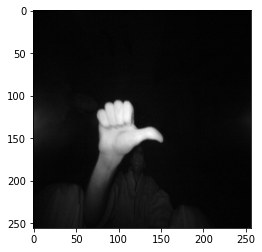

In [29]:
plt.imshow((image[0][0]), cmap='gray')
plt.show()

In [30]:
index_to_class[class_index[0].item()]

'05_thumb'

## Создание класса модели

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64*4*4)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
# Проверим правильность работы сети, прогнав через нее картинку
net = Net().to(device)
result = net(image.to(device))
result.shape

torch.Size([16, 10])

In [ ]:
result = torch.argmax(result, dim=1)
result

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')

In [ ]:
class_index

tensor([4, 9, 1, 5, 6, 0, 2, 4, 8, 6, 9, 5, 4, 6, 9, 1])

In [ ]:
float(torch.sum(result == class_index.to(device)).item())

0.0

## Обучение модели

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
epoch_losses = []
batch_size = 16
num_epochs = 3

for epoch in range(num_epochs):  
    train_loss = 0.0
    train_acc  = 0.0

    epoch_loss = []
    epoch_accuracy = []
    time1 = time.time()

    for batch_idx, data in enumerate(train_data_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        accuracy = float(torch.sum(torch.argmax(outputs, dim=1) == labels).item())/batch_size
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy
        epoch_loss.append(loss.item())
        epoch_accuracy.append(accuracy)
        if (batch_idx+1) % 100 == 99:
            print(f'Train Epoch: {epoch+1}, Train loss: {train_loss/100:.4f}, Train accuracy: {train_acc/100:.4f}')
            time2 = time.time()
            print(f'Spend time for 100 batches: {time2 - time1:.4f} sec')
            time1 = time.time()
            train_loss = 0.0
            train_acc  = 0.0

    total_steps = len(test_data_loader)
    val_loss = 0.0
    val_acc  = 0.0
    with torch.no_grad():
        for data in test_data_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            val_acc += float(torch.sum(torch.argmax(outputs, dim=1) == labels).item())/batch_size
            loss = criterion(outputs, labels)
            val_loss += loss
    print(f'Epoch {epoch+1}, Train loss: {np.mean(epoch_loss):.4f}, '
                           f'Train acc: {np.mean(epoch_accuracy):.4f}, ' 
                           f'Validate loss: {val_loss/total_steps:.4f}, ' 
                           f'Validate acc: {val_acc/total_steps:.4f}')
    epoch_losses.append(epoch_loss) 

print('Training is finished!')

Train Epoch: 1, Train loss: 1.8616, Train accuracy: 0.3150
Spend time for 100 batches: 10.5511 sec
Train Epoch: 1, Train loss: 0.7208, Train accuracy: 0.7781
Spend time for 100 batches: 10.5070 sec
Train Epoch: 1, Train loss: 0.3682, Train accuracy: 0.8838
Spend time for 100 batches: 10.4948 sec
Train Epoch: 1, Train loss: 0.1667, Train accuracy: 0.9513
Spend time for 100 batches: 10.5699 sec
Train Epoch: 1, Train loss: 0.0990, Train accuracy: 0.9694
Spend time for 100 batches: 10.5120 sec
Train Epoch: 1, Train loss: 0.1220, Train accuracy: 0.9575
Spend time for 100 batches: 10.4772 sec
Train Epoch: 1, Train loss: 0.0569, Train accuracy: 0.9850
Spend time for 100 batches: 10.4946 sec
Train Epoch: 1, Train loss: 0.0795, Train accuracy: 0.9762
Spend time for 100 batches: 10.5747 sec
Epoch 1, Train loss: 0.4029, Train acc: 0.8635, Validate loss: 0.0384, Validate acc: 0.9887
Train Epoch: 2, Train loss: 0.0537, Train accuracy: 0.9700
Spend time for 100 batches: 10.3777 sec
Train Epoch: 2, T

Text(0.5, 1.0, 'losses vs. No. of epochs')

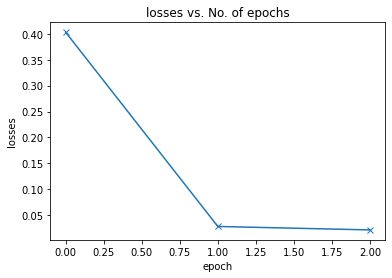

In [ ]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

## Вывод полученных результатов

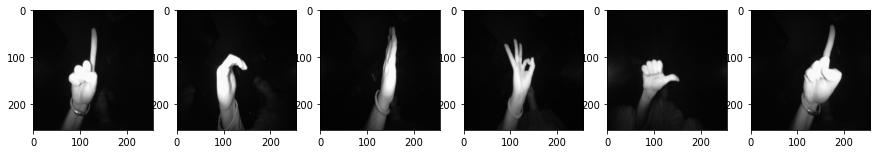

GroundTruth:         06_index            09_c   08_palm_moved           07_ok        05_thumb        06_index
Predicted:           06_index            09_c   08_palm_moved           07_ok        05_thumb        06_index


In [ ]:
N=6

test_loader = DataLoader(test_data, batch_size = N, shuffle=True)

data_iter = iter(test_loader)
images, labels = data_iter.next()
net = net.to(device)
outputs = net(images.to(device))

f, axarr = plt.subplots(1,N, figsize=(15,15))
for i in range(N):
  axarr[i].imshow(images[i].numpy()[0], cmap='gray')
  axarr[i].imshow(images[i].numpy()[0], cmap='gray')
  axarr[i].imshow(images[i].numpy()[0], cmap='gray')
plt.show()

print('GroundTruth: ', ' '.join('%15s' % index_to_class[labels[j].item()] for j in range(N)))
_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%15s' % index_to_class[predicted[j].item()] for j in range(N)))

## Сохранение модели

In [ ]:
torch.save(net, '/content/hand_model.pth')